# 🌿 Baseline MS (Multispectral) - ResNet18
## Beyond Visible Spectrum: AI for Agriculture 2026

**Multispectral Bands:**
- Band 0: Blue
- Band 1: Green
- Band 2: Red
- Band 3: Red-edge
- Band 4: Near Infrared (NIR)

**Pipeline:**
1. EDA & Data Loading
2. Dataset & DataLoader (5 channels)
3. Model: ResNet18 modified for 5 channels
4. Training với WandB logging
5. Evaluation & Confusion Matrix
6. Inference & Submission

## 1. Imports & Config

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
from collections import Counter, defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import wandb

# Config
CONFIG = {
    "seed": 42,
    "img_size": 64,
    "batch_size": 32,
    "epochs": 10,
    "lr": 1e-4,
    "val_split": 0.2,
    "num_classes": 3,
    "in_channels": 5,  # MS có 5 bands
    "model_name": "resnet18",
}

# Paths - LOCAL
TRAIN_MS_DIR = r"D:\HocTap\NCKH_ThayDoNhuTai\Challenges\data\raw\train\MS"
TEST_MS_DIR = r"D:\HocTap\NCKH_ThayDoNhuTai\Challenges\data\raw\val\MS"
CHECKPOINT_DIR = r"D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints"

# # Paths - KAGGLE
# TRAIN_MS_DIR = "/kaggle/input/beyond-visible-spectrum/train/MS"
# TEST_MS_DIR = "/kaggle/input/beyond-visible-spectrum/test/MS"
# CHECKPOINT_DIR = "/kaggle/working"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# Set seed
np.random.seed(CONFIG["seed"])
torch.manual_seed(CONFIG["seed"])
if torch.cuda.is_available():
    torch.cuda.manual_seed(CONFIG["seed"])

Device: cuda


## 2. EDA - Exploratory Data Analysis

Total images: 577
Classes: {'Health': 191, 'Other': 186, 'Rust': 200}


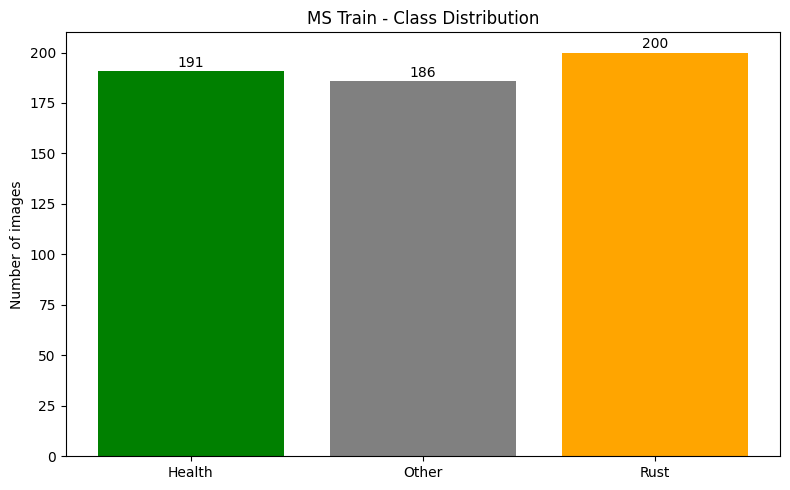

In [2]:
def label_from_filename(fname: str) -> str:
    """Extract label from filename: 'Rust_hyper_184.tif' -> 'Rust'"""
    return os.path.basename(fname).split("_")[0]

# Count images per class
files = [f for f in os.listdir(TRAIN_MS_DIR) if f.lower().endswith((".tif", ".tiff"))]
class_counts = Counter(label_from_filename(f) for f in files)

print(f"Total images: {len(files)}")
print(f"Classes: {dict(class_counts)}")

# Plot distribution
plt.figure(figsize=(8, 5))
classes = sorted(class_counts.keys())
counts = [class_counts[c] for c in classes]
plt.bar(classes, counts, color=['green', 'gray', 'orange'])
plt.ylabel('Number of images')
plt.title('MS Train - Class Distribution')
for i, v in enumerate(counts):
    plt.text(i, v + 2, str(v), ha='center')
plt.tight_layout()
plt.show()

In [3]:
# Explore MS image properties
sample_file = files[0]
sample_path = os.path.join(TRAIN_MS_DIR, sample_file)
arr = tiff.imread(sample_path)

print(f"File: {sample_file}")
print(f"Original shape: {arr.shape}")
print(f"Dtype: {arr.dtype}")
print(f"Min/Max: {arr.min()} / {arr.max()}")

# Normalize shape to (H, W, C)
if arr.ndim == 3 and arr.shape[0] < 20 and arr.shape[0] != arr.shape[-1]:
    arr = np.transpose(arr, (1, 2, 0))
    print(f"Transposed shape: {arr.shape}")

H, W, C = arr.shape
print(f"\nImage size: {H}x{W}")
print(f"Number of bands: {C}")

File: Health_hyper_1.tif
Original shape: (64, 64, 5)
Dtype: uint16
Min/Max: 272 / 4936

Image size: 64x64
Number of bands: 5


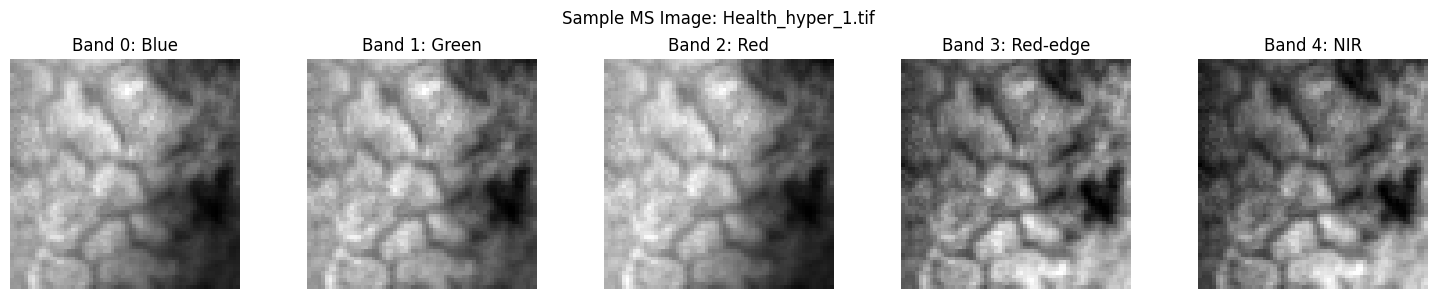

In [4]:
# Visualize all 5 bands
band_names = ["Blue", "Green", "Red", "Red-edge", "NIR"]

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for b in range(C):
    band = arr[:, :, b]
    axes[b].imshow(band, cmap='gray')
    axes[b].set_title(f"Band {b}: {band_names[b]}")
    axes[b].axis('off')

plt.suptitle(f"Sample MS Image: {sample_file}")
plt.tight_layout()
plt.show()

In [5]:
# # Band histogram per class
# band_stats = defaultdict(lambda: {"sum": 0.0, "sq": 0.0, "n": 0})

# for f in files[:100]:  # Sample 100 files for speed
#     label = label_from_filename(f)
#     arr = tiff.imread(os.path.join(TRAIN_MS_DIR, f))
    
#     if arr.ndim == 3 and arr.shape[0] < 20 and arr.shape[0] != arr.shape[-1]:
#         arr = np.transpose(arr, (1, 2, 0))
    
#     arr = arr.astype(np.float32)
#     arr = arr / (arr.max() + 1e-8)
    
#     for b in range(arr.shape[2]):
#         band = arr[:, :, b]
#         band_stats[(label, b)]["sum"] += band.mean()
#         band_stats[(label, b)]["sq"] += band.std()
#         band_stats[(label, b)]["n"] += 1

# # Print stats
# labels = sorted(set(label_from_filename(f) for f in files))
# print("Band Statistics by Class:")
# print("=" * 50)

# for b in range(5):
#     print(f"\nBand {b} ({band_names[b]}):")
#     for lbl in labels:
#         s = band_stats[(lbl, b)]
#         if s["n"] > 0:
#             mean = s["sum"] / s["n"]
#             std = s["sq"] / s["n"]
#             print(f"  {lbl:8s} | mean={mean:.4f}  std={std:.4f}")

In [6]:
import tifffile as tiff
from tqdm import tqdm

def compute_global_stats(img_dir):
    print("Computing global stats...")
    files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.tif', '.tiff'))]
    
    # Khởi tạo s1 (tổng) và s2 (tổng bình phương) cho 5 kênh
    channels = 5
    pixel_num = 0 # Tổng số pixel đã duyệt
    channel_sum = np.zeros(channels)
    channel_sum_sq = np.zeros(channels) 

    for f in tqdm(files):
        path = os.path.join(img_dir, f)
        img = tiff.imread(path).astype(np.float32)
        
        # Xử lý shape (H, W, C)
        if img.ndim == 3 and img.shape[0] == 5: # Nếu là (C, H, W)
            img = np.transpose(img, (1, 2, 0))
            
        # Normalize sơ bộ về khoảng [0, 1] dựa trên bit-depth (uint16)
        # Giá trị max của uint16 là 65535, nhưng dữ liệu vệ tinh thường chỉ dùng ~10000-20000.
        # Ở đây ta giữ nguyên giá trị raw hoặc chia cho 1 hằng số cố định (ví dụ 65535) nếu muốn.
        # Tốt nhất là tính trên giá trị Raw để chính xác nhất.
        
        # Reshape thành (N, C) để tính toán dễ hơn
        pixels = img.reshape(-1, channels)
        
        channel_sum += pixels.sum(axis=0)
        channel_sum_sq += (pixels ** 2).sum(axis=0)
        pixel_num += pixels.shape[0]
    
    # Tính mean và std
    mean = channel_sum / pixel_num
    std = np.sqrt(channel_sum_sq / pixel_num - mean ** 2)
    
    return mean, std

# Chạy hàm này trên tập TRAIN
# mean, std = compute_global_stats(TRAIN_MS_DIR)
# print(f"Mean: {mean}")
# print(f"Std: {std}")

## 3. Dataset & DataLoader

In [7]:
import tifffile as tiff
from tqdm import tqdm

def compute_global_stats(img_dir, file_list=None):
    """
    Compute global mean and std for normalization.
    If file_list is provided, only compute stats on those files (for train split only).
    """
    print("Computing global stats (Mean & Std)...")
    if file_list is not None:
        files = file_list
        print(f"  Using provided file_list: {len(files)} files")
    else:
        files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.tif', '.tiff'))]
        print(f"  Using all files in directory: {len(files)} files")
    
    channels = 5
    pixel_num = 0
    channel_sum = np.zeros(channels)
    channel_sum_sq = np.zeros(channels) 

    for f in tqdm(files, desc="Computing stats"):
        path = os.path.join(img_dir, f)
        img = tiff.imread(path).astype(np.float32)
        
        # Handle shape (H, W, C)
        if img.ndim == 3 and img.shape[0] == 5 and img.shape[-1] != 5:
            img = np.transpose(img, (1, 2, 0))
            
        # Normalize to [0, 1] range (assuming 16-bit input)
        img = img / 65535.0
        
        pixels = img.reshape(-1, channels)
        
        channel_sum += pixels.sum(axis=0)
        channel_sum_sq += (pixels ** 2).sum(axis=0)
        pixel_num += pixels.shape[0]
    
    mean = channel_sum / pixel_num
    std = np.sqrt(channel_sum_sq / pixel_num - mean ** 2)
    
    print(f"Global Mean: {mean}")
    print(f"Global Std:  {std}")
    return mean, std

class MSDataset(Dataset):
    """Multispectral Image Dataset - loads TIFF images with 5 bands"""
    
    def __init__(self, img_dir, file_list=None, img_size=64, augment=False, mean=None, std=None):
        self.img_dir = img_dir
        self.img_size = img_size
        self.augment = augment
        
        # Store global stats for normalization
        self.mean = torch.tensor(mean).view(5, 1, 1).float() if mean is not None else torch.zeros(5, 1, 1)
        self.std = torch.tensor(std).view(5, 1, 1).float() if std is not None else torch.ones(5, 1, 1)
        
        if file_list is not None:
            self.files = file_list
        else:
            self.files = sorted([f for f in os.listdir(img_dir) 
                                if f.lower().endswith((".tif", ".tiff"))])
        
        # Create label mapping
        labels = sorted({label_from_filename(f) for f in self.files})
        self.class_to_idx = {c: i for i, c in enumerate(labels)}
        self.idx_to_class = {i: c for c, i in self.class_to_idx.items()}
        self.y = [self.class_to_idx[label_from_filename(f)] for f in self.files]
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        fname = self.files[idx]
        label = self.y[idx]
        
        # Load TIFF
        path = os.path.join(self.img_dir, fname)
        arr = tiff.imread(path)
        
        # Normalize shape to (H, W, C)
        if arr.ndim == 2:
            arr = arr[..., None]
        elif arr.ndim == 3 and arr.shape[0] == 5 and arr.shape[-1] != 5:
            arr = np.transpose(arr, (1, 2, 0))
        
        # Convert to float32 and scale to [0, 1] using fixed constant
        arr = arr.astype(np.float32)
        arr = arr / 65535.0
        
        # Convert to tensor (C, H, W)
        x = torch.from_numpy(arr).permute(2, 0, 1)
        
        # Z-score Normalization (Global standardization)
        x = (x - self.mean) / (self.std + 1e-8)
        
        # Resize
        x = x.unsqueeze(0)
        x = F.interpolate(x, size=(self.img_size, self.img_size), 
                         mode="bilinear", align_corners=False)
        x = x.squeeze(0)
        
        # Augmentation (for training)
        if self.augment:
            # Random horizontal flip
            if torch.rand(1) > 0.5:
                x = torch.flip(x, dims=[2])
            # Random vertical flip
            if torch.rand(1) > 0.5:
                x = torch.flip(x, dims=[1])
            # Random 90 degree rotation
            k = torch.randint(0, 4, (1,)).item()
            x = torch.rot90(x, k, dims=[1, 2])
        
        return x, label


class MSTestDataset(Dataset):
    """MS Test Dataset - returns image and filename (no label)"""
    
    def __init__(self, img_dir, img_size=64, mean=None, std=None):
        self.img_dir = img_dir
        self.img_size = img_size
        self.mean = torch.tensor(mean).view(5, 1, 1).float() if mean is not None else torch.zeros(5, 1, 1)
        self.std = torch.tensor(std).view(5, 1, 1).float() if std is not None else torch.ones(5, 1, 1)
        
        self.files = sorted([f for f in os.listdir(img_dir) 
                            if f.lower().endswith((".tif", ".tiff"))])
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        fname = self.files[idx]
        path = os.path.join(self.img_dir, fname)
        arr = tiff.imread(path)
        
        # Normalize shape
        if arr.ndim == 2:
            arr = arr[..., None]
        elif arr.ndim == 3 and arr.shape[0] == 5 and arr.shape[-1] != 5:
            arr = np.transpose(arr, (1, 2, 0))
        
        arr = arr.astype(np.float32)
        arr = arr / 65535.0
        
        x = torch.from_numpy(arr).permute(2, 0, 1)
        
        # Z-score normalize
        x = (x - self.mean) / (self.std + 1e-8)
        
        # Resize
        x = x.unsqueeze(0)
        x = F.interpolate(x, size=(self.img_size, self.img_size), 
                         mode="bilinear", align_corners=False)
        x = x.squeeze(0)
        
        return x, fname

In [8]:
import pandas as pd

# ============================================================
# Load SHARED SPLIT (công bằng giữa RGB / MS / HS)
# ============================================================
SPLIT_DIR = r"D:\HocTap\NCKH_ThayDoNhuTai\Challenges\Notebooks\split\splits"

df_master = pd.read_csv(os.path.join(SPLIT_DIR, "samples_master.csv"))
train_idx = np.load(os.path.join(SPLIT_DIR, "train_idx.npy"))
val_idx   = np.load(os.path.join(SPLIT_DIR, "val_idx.npy"))

df_train = df_master.iloc[train_idx].reset_index(drop=True)
df_val   = df_master.iloc[val_idx].reset_index(drop=True)

# Lấy filename từ ms_path (basename, không phụ thuộc root)
train_files = [os.path.basename(p) for p in df_train["ms_path"]]
val_files   = [os.path.basename(p) for p in df_val["ms_path"]]

print(f"Shared split loaded from: {SPLIT_DIR}")
print(f"  Total aligned samples: {len(df_master)}")
print(f"  Train: {len(train_files)} | Val: {len(val_files)}")

# Verify files exist in TRAIN_MS_DIR
missing = [f for f in train_files + val_files if not os.path.exists(os.path.join(TRAIN_MS_DIR, f))]
if missing:
    print(f"  ⚠️ Missing {len(missing)} files! First 5: {missing[:5]}")
else:
    print(f"  ✓ All files exist in {TRAIN_MS_DIR}")

# ============================================================
# Compute stats ONLY on train split (avoid data leakage)
# ============================================================
mean_stats, std_stats = compute_global_stats(TRAIN_MS_DIR, file_list=train_files)

# ============================================================
# Create datasets with shared split
# ============================================================
train_ds = MSDataset(TRAIN_MS_DIR, file_list=train_files,
                     img_size=CONFIG["img_size"], augment=True,
                     mean=mean_stats, std=std_stats)
val_ds = MSDataset(TRAIN_MS_DIR, file_list=val_files,
                   img_size=CONFIG["img_size"], augment=False,
                   mean=mean_stats, std=std_stats)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=CONFIG["batch_size"], 
                         shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=CONFIG["batch_size"], 
                       shuffle=False, num_workers=0)

print(f"\nTrain samples: {len(train_ds)}")
print(f"Val samples: {len(val_ds)}")
print(f"Classes: {train_ds.class_to_idx}")

# Verify shapes
x, y = next(iter(train_loader))
print(f"Batch shape: {x.shape}")

Shared split loaded from: D:\HocTap\NCKH_ThayDoNhuTai\Challenges\Notebooks\split\splits
  Total aligned samples: 577
  Train: 461 | Val: 116
  ✓ All files exist in D:\HocTap\NCKH_ThayDoNhuTai\Challenges\data\raw\train\MS
Computing global stats (Mean & Std)...
  Using provided file_list: 461 files


Computing stats: 100%|██████████| 461/461 [00:07<00:00, 58.02it/s]


Global Mean: [0.00651217 0.01202489 0.01260268 0.03442739 0.04236133]
Global Std:  [0.00558527 0.0067257  0.00985042 0.01149776 0.01547735]

Train samples: 461
Val samples: 116
Classes: {'Health': 0, 'Other': 1, 'Rust': 2}
Batch shape: torch.Size([32, 5, 64, 64])


## 4. Model Definition

In [9]:
def create_ms_model(in_channels, num_classes, pretrained=True):
    """
    Create ResNet18 model modified for multispectral input (5 channels)
    
    Strategy: Initialize first conv layer to accept 5 channels by
    averaging the pretrained RGB weights and replicating.
    """
    if pretrained:
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    else:
        model = models.resnet18(weights=None)
    
    # Save original conv1
    old_conv = model.conv1
    
    # Create new conv1 for 5 channels
    model.conv1 = nn.Conv2d(
        in_channels, 
        old_conv.out_channels,
        kernel_size=old_conv.kernel_size,
        stride=old_conv.stride,
        padding=old_conv.padding,
        bias=False
    )
    
    # Initialize with averaged pretrained weights
    if pretrained:
        with torch.no_grad():
            # Average RGB weights → neutral kernel
            w_avg = old_conv.weight.mean(dim=1, keepdim=True)  # (64, 1, 7, 7)
            # Replicate for all 5 channels
            model.conv1.weight.copy_(w_avg.repeat(1, in_channels, 1, 1))
    
    # Replace final FC layer
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    return model


model = create_ms_model(
    in_channels=CONFIG["in_channels"],
    num_classes=CONFIG["num_classes"],
    pretrained=True
)
model = model.to(device)

print(f"Model: {CONFIG['model_name']} (modified for {CONFIG['in_channels']} channels)")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

# Verify forward pass
with torch.no_grad():
    dummy = torch.randn(2, 5, 64, 64).to(device)
    out = model(dummy)
    print(f"Output shape: {out.shape}  (expected: [2, {CONFIG['num_classes']}])")

Model: resnet18 (modified for 5 channels)
Parameters: 11,184,323
Output shape: torch.Size([2, 3])  (expected: [2, 3])


## 5. Training

In [10]:
def train_one_epoch(model, loader, criterion, optimizer):
    """Train for one epoch"""
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    return total_loss / total, correct / total


@torch.no_grad()
def evaluate(model, loader, criterion):
    """Evaluate model"""
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        total_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    return total_loss / total, correct / total

In [11]:
# Initialize WandB
wandb.init(
    project="beyond-visible-spectrum",
    name=f"baseline_ms_{CONFIG['model_name']}",
    config=CONFIG
)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=CONFIG["lr"])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3
)

# Training loop
best_val_acc = 0.0
best_model_path = os.path.join(CHECKPOINT_DIR, "best_ms_resnet18.pth")

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(1, CONFIG["epochs"] + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    
    # Scheduler step
    scheduler.step(val_acc)
    
    # Log to WandB
    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
        "lr": optimizer.param_groups[0]['lr']
    })
    
    # Save history
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"Epoch {epoch:02d} | train_acc={train_acc:.4f} val_acc={val_acc:.4f} ⭐ BEST")
    else:
        print(f"Epoch {epoch:02d} | train_acc={train_acc:.4f} val_acc={val_acc:.4f}")

wandb.finish()
print(f"\n✓ Best val_acc: {best_val_acc:.4f}")
print(f"✓ Model saved to: {best_model_path}")

wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from C:\Users\ADMIN\_netrc.
wandb: Currently logged in as: phucga150625 (phucga15062005) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 01 | train_acc=0.5033 val_acc=0.5259 ⭐ BEST
Epoch 02 | train_acc=0.6030 val_acc=0.6121 ⭐ BEST
Epoch 03 | train_acc=0.6269 val_acc=0.5776
Epoch 04 | train_acc=0.6898 val_acc=0.6121
Epoch 05 | train_acc=0.6725 val_acc=0.6207 ⭐ BEST
Epoch 06 | train_acc=0.7245 val_acc=0.5948
Epoch 07 | train_acc=0.7527 val_acc=0.5259
Epoch 08 | train_acc=0.7657 val_acc=0.5948
Epoch 09 | train_acc=0.7852 val_acc=0.6207
Epoch 10 | train_acc=0.8373 val_acc=0.6379 ⭐ BEST


epoch,▁▂▃▃▄▅▆▆▇█
lr,████████▁▁
train_acc,▁▃▄▅▅▆▆▇▇█
train_loss,█▆▅▄▅▃▃▂▂▁
val_acc,▁▆▄▆▇▅▁▅▇█
val_loss,█▁▃▅▃▅▇▆▇▇
epoch,10
lr,5e-05
train_acc,0.83731
train_loss,0.44846
val_acc,0.63793



✓ Best val_acc: 0.6379
✓ Model saved to: D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints\best_ms_resnet18.pth


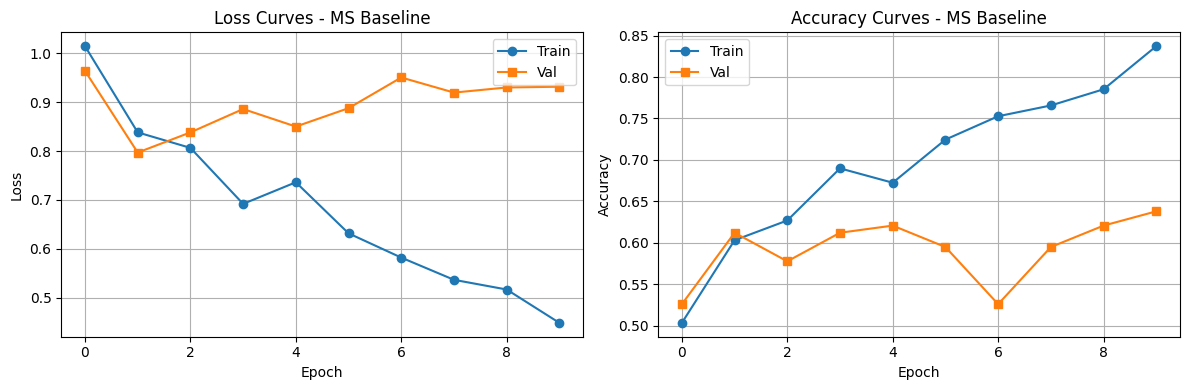

In [12]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss
axes[0].plot(history["train_loss"], label="Train", marker='o')
axes[0].plot(history["val_loss"], label="Val", marker='s')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss Curves - MS Baseline")
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(history["train_acc"], label="Train", marker='o')
axes[1].plot(history["val_acc"], label="Val", marker='s')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Accuracy Curves - MS Baseline")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 6. Evaluation

In [13]:
# Load best model
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

# Get predictions on validation set
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        
        y_true.extend(labels.numpy())
        y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
class_names = [val_ds.idx_to_class[i] for i in range(CONFIG["num_classes"])]
print("Classification Report (MS Baseline):")
print("=" * 50)
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report (MS Baseline):
              precision    recall  f1-score   support

      Health       0.55      0.62      0.58        39
       Other       0.79      0.73      0.76        37
        Rust       0.61      0.57      0.59        40

    accuracy                           0.64       116
   macro avg       0.65      0.64      0.64       116
weighted avg       0.65      0.64      0.64       116



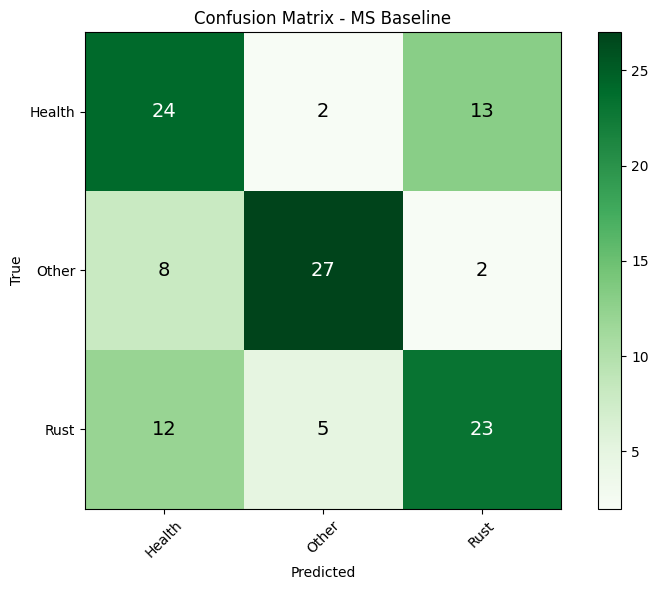

In [14]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Confusion Matrix - MS Baseline")
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=14)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [15]:
import os
import numpy as np
import torch
from tqdm import tqdm
from PIL import Image
import tifffile as tiff


# =========================
# 1) Load best checkpoint
# =========================
def load_best_model(model, best_model_path, device):
    state = torch.load(best_model_path, map_location=device)
    model.load_state_dict(state)
    model.to(device)
    model.eval()
    print(f"Loaded best weights: {best_model_path}")
    return model


# ======================================
# 2) Export OK/FAIL for RGB (PNG images)
# ======================================
@torch.no_grad()
def export_ok_fail_rgb(
    model,
    ds,                 # val_ds (RGBDataset)
    device,
    out_dir,
    n_ok=20,
    n_fail=20
):
    model.eval()
    os.makedirs(out_dir, exist_ok=True)
    ok_dir = os.path.join(out_dir, "ok")
    fail_dir = os.path.join(out_dir, "fail")
    os.makedirs(ok_dir, exist_ok=True)
    os.makedirs(fail_dir, exist_ok=True)

    ok_count, fail_count = 0, 0

    for i in tqdm(range(len(ds)), desc="Export RGB OK/FAIL"):
        x, y = ds[i]  # x: tensor [3,H,W], y: int
        x = x.unsqueeze(0).to(device)
        y = int(y)

        logits = model(x)
        pred = int(logits.argmax(dim=1).item())

        true_name = ds.idx_to_class[y]
        pred_name = ds.idx_to_class[pred]
        fname = ds.files[i]

        # load raw image to save (not normalized)
        raw_path = os.path.join(ds.img_dir, fname)
        raw_img = Image.open(raw_path).convert("RGB")

        if pred == y and ok_count < n_ok:
            save_name = f"OK_true-{true_name}_pred-{pred_name}_{fname}"
            raw_img.save(os.path.join(ok_dir, save_name))
            ok_count += 1

        elif pred != y and fail_count < n_fail:
            save_name = f"FAIL_true-{true_name}_pred-{pred_name}_{fname}"
            raw_img.save(os.path.join(fail_dir, save_name))
            fail_count += 1

        if ok_count >= n_ok and fail_count >= n_fail:
            break

    print(f"\nSaved OK   : {ok_count} -> {ok_dir}")
    print(f"Saved FAIL : {fail_count} -> {fail_dir}")


# ==================================================
# 3) Export OK/FAIL for MS (TIFF 5-band multispectral)
# ==================================================
def _ms_to_vis_rgb(raw, channels=5):
    """
    raw: numpy array of shape (H,W,C) or (C,H,W) or (H,W)
    return: uint8 RGB image (H,W,3) for visualization
    """
    if raw.ndim == 2:
        raw = raw[..., None]

    # convert (C,H,W) -> (H,W,C) if needed
    if raw.ndim == 3 and raw.shape[0] == channels and raw.shape[-1] != channels:
        raw = np.transpose(raw, (1, 2, 0))

    raw = raw.astype(np.float32)

    # if still not (H,W,>=3), pad
    if raw.ndim != 3:
        raise ValueError("Invalid MS shape")
    if raw.shape[-1] < 3:
        raw = np.concatenate([raw] + [raw[..., -1:]] * (3 - raw.shape[-1]), axis=-1)

    # take first 3 bands as pseudo-RGB
    vis = raw[..., :3]

    # autoscale per-image (robust) to [0,1]
    vmin = np.percentile(vis, 1)
    vmax = np.percentile(vis, 99)
    vis = (vis - vmin) / (vmax - vmin + 1e-6)
    vis = np.clip(vis, 0, 1)

    return (vis * 255).astype(np.uint8)


@torch.no_grad()
def export_ok_fail_ms(
    model,
    ds,                 # val_ds (MSDataset)
    device,
    out_dir,
    n_ok=20,
    n_fail=20
):
    model.eval()
    os.makedirs(out_dir, exist_ok=True)
    ok_dir = os.path.join(out_dir, "ok")
    fail_dir = os.path.join(out_dir, "fail")
    os.makedirs(ok_dir, exist_ok=True)
    os.makedirs(fail_dir, exist_ok=True)

    ok_count, fail_count = 0, 0

    for i in tqdm(range(len(ds)), desc="Export MS OK/FAIL"):
        x, y = ds[i]  # x: tensor [5,H,W] (normalized), y: int
        x = x.unsqueeze(0).to(device)
        y = int(y)

        logits = model(x)
        pred = int(logits.argmax(dim=1).item())

        true_name = ds.idx_to_class[y]
        pred_name = ds.idx_to_class[pred]
        fname = ds.files[i]

        # Load raw TIFF for visualization
        raw_path = os.path.join(ds.img_dir, fname)
        raw = tiff.imread(raw_path)

        try:
            vis_rgb = _ms_to_vis_rgb(raw, channels=5)
        except Exception:
            # fallback: blank
            vis_rgb = np.zeros((ds.img_size, ds.img_size, 3), dtype=np.uint8)

        out_img = Image.fromarray(vis_rgb)

        if pred == y and ok_count < n_ok:
            save_name = f"OK_true-{true_name}_pred-{pred_name}_{fname}.png"
            out_img.save(os.path.join(ok_dir, save_name))
            ok_count += 1

        elif pred != y and fail_count < n_fail:
            save_name = f"FAIL_true-{true_name}_pred-{pred_name}_{fname}.png"
            out_img.save(os.path.join(fail_dir, save_name))
            fail_count += 1

        if ok_count >= n_ok and fail_count >= n_fail:
            break

    print(f"\nSaved OK   : {ok_count} -> {ok_dir}")
    print(f"Saved FAIL : {fail_count} -> {fail_dir}")


# =========================
# 4) Example usage
# =========================

# --- For RGB ---
# model = load_best_model(model, best_model_path, device)
# export_ok_fail_rgb(
#     model=model,
#     ds=val_ds,
#     device=device,
#     out_dir="results/rgb_examples",
#     n_ok=20,
#     n_fail=20
# )

#  --- For MS ---
model = load_best_model(model, best_model_path, device)
export_ok_fail_ms(
    model=model,
    ds=val_ds,
    device=device,
    out_dir=os.path.join(CHECKPOINT_DIR, "Exemple_MS_ResNet18"),
    n_ok=20,
    n_fail=20
)



Loaded best weights: D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints\best_ms_resnet18.pth


Export MS OK/FAIL:  34%|███▎      | 39/116 [00:00<00:00, 86.13it/s] 


Saved OK   : 20 -> D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints\Exemple_MS_ResNet18\ok
Saved FAIL : 20 -> D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints\Exemple_MS_ResNet18\fail


In [16]:
# export_ok_fail_ms(
#     model=model,
#     ds=val_ds,   # dùng VAL nhé
#     out_dir=os.path.join(CHECKPOINT_DIR, "val_examplesMS"),
#     n_ok=20,
#     n_fail=20
# )


## 7. Inference & Submission

In [17]:
# # Check if test directory exists
# if os.path.exists(TEST_MS_DIR):
#     # Note: Using stats computed during training
#     test_ds = MSTestDataset(TEST_MS_DIR, img_size=CONFIG["img_size"], mean=mean_stats, std=std_stats)
#     test_loader = DataLoader(test_ds, batch_size=CONFIG["batch_size"], 
#                             shuffle=False, num_workers=0)
#     print(f"Test samples: {len(test_ds)}")
# else:
#     print(f"⚠️ Test directory not found: {TEST_MS_DIR}")
#     print("Skipping test inference...")


In [18]:
# # Run inference on test set
# if os.path.exists(TEST_MS_DIR):
#     model.eval()
#     predictions = []
#     filenames = []
    
#     idx_to_class = val_ds.idx_to_class
    
#     with torch.no_grad():
#         for images, fnames in test_loader:
#             images = images.to(device)
#             outputs = model(images)
#             preds = outputs.argmax(dim=1).cpu().numpy()
            
#             # Convert to class names
#             pred_labels = [idx_to_class[p] for p in preds]
            
#             predictions.extend(pred_labels)
#             filenames.extend(fnames)
    
#     print(f"✓ Predicted {len(predictions)} test samples")
#     print(f"Sample predictions: {list(zip(filenames[:5], predictions[:5]))}")

In [19]:
# # Create submission CSV
# import pandas as pd

# if os.path.exists(TEST_MS_DIR):
#     submission_df = pd.DataFrame({
#         'ID': filenames,
#         'label': predictions
#     })
    
#     # Sort by filename
#     submission_df = submission_df.sort_values('ID').reset_index(drop=True)
    
#     # Save
#     submission_path = os.path.join(CHECKPOINT_DIR, "submission_ms.csv")
#     submission_df.to_csv(submission_path, index=False)
    
#     print(f"✓ Saved submission to: {submission_path}")
#     print(f"✓ Total predictions: {len(submission_df)}")
#     print(f"\nFirst 10 rows:")
#     print(submission_df.head(10))
#     print(f"\nLabel distribution:")
#     print(submission_df['label'].value_counts())
# else:
#     print("⚠️ No test data - submission not created")

## 8. Overfitting Analysis

In [20]:
# # Check for potential overfitting signs
# print("=" * 50)
# print("OVERFITTING ANALYSIS - MS BASELINE")
# print("=" * 50)

# print(f"\n📊 Dataset Info:")
# print(f"   Total images: {len(base_ds)}")
# print(f"   Train/Val split: {len(train_ds)}/{len(val_ds)}")
# print(f"   Input channels: {CONFIG['in_channels']}")

# # Gap between train and val accuracy
# final_train_acc = history["train_acc"][-1]
# final_val_acc = history["val_acc"][-1]
# gap = final_train_acc - final_val_acc

# print(f"\n📈 Performance:")
# print(f"   Final Train Accuracy: {final_train_acc:.4f}")
# print(f"   Final Val Accuracy: {final_val_acc:.4f}")
# print(f"   Gap (Train - Val): {gap:.4f}")

# print(f"\n🔍 Diagnosis:")
# if gap > 0.15:
#     print("   ⚠️ LARGE GAP - Strong overfitting detected!")
#     print("   Suggestions:")
#     print("   - Add more augmentation")
#     print("   - Add dropout")
#     print("   - Use early stopping")
#     print("   - Reduce model complexity")
# elif gap > 0.1:
#     print("   ⚠️ MODERATE GAP - Some overfitting")
#     print("   Consider adding regularization")
# elif final_val_acc > 0.95:
#     print("   ⚠️ VERY HIGH VAL_ACC - Check for data leakage!")
#     print("   - Verify train/val split is correct")
#     print("   - Check if images are too similar")
# else:
#     print("   ✓ Gap looks reasonable")
#     print("   Model generalizes well")

## 9. Save Model for Kaggle Submission

In [21]:
# # Save complete model info for reproducibility
# model_info = {
#     "config": CONFIG,
#     "class_to_idx": train_ds.class_to_idx,
#     "idx_to_class": train_ds.idx_to_class,
#     "best_val_acc": best_val_acc,
#     "history": history
# }

# import json
# info_path = os.path.join(CHECKPOINT_DIR, "ms_model_info.json")
# with open(info_path, 'w') as f:
#     json.dump(model_info, f, indent=2)

# print(f"✓ Model info saved to: {info_path}")
# print(f"✓ Model weights saved to: {best_model_path}")
# print(f"\n📋 To use on Kaggle:")
# print("   1. Upload .pth file as dataset")
# print("   2. Change paths to Kaggle paths")
# print("   3. Load model and run inference on test set")